In [79]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_squared_error


import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Загрузим датасет

In [80]:
df = pd.read_csv('dataset.csv', header=0, infer_datetime_format=True,
                   parse_dates=['course_finished_date'], index_col=['course_finished_date'])

/var/folders/4d/01h37whs1gsddkj2yj7jszjh0000gn/T/ipykernel_32343/2255855955.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv('dataset.csv', header=0, infer_datetime_format=True,


Отберем признаки дляобучения и разделим выборку на тестовую и тренировочную

In [82]:
y = df['course_duration_sum']
X = df.drop(['course_duration_sum'], axis=1)

In [83]:
X_train = X[14:365]
X_valid = X[365:-30]
y_train = y[14:365]
y_valid = y[365:-30]

Методом градиентного спуска найдем лучший конфиг обучения деревьев с учетом метрики MSE

In [85]:
parameters = {    
    'n_estimators': [216, 217, 218],
    'min_samples_leaf': np.arange(1, 8),
    'max_depth': np.arange(5, 10)
}


clf = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=parameters,
    scoring='neg_mean_squared_error',
    cv=10,  
    n_jobs = -1
)

In [86]:
clf.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': array([5, 6, 7, 8, 9]),
                         'min_samples_leaf': array([1, 2, 3, 4, 5, 6, 7]),
                         'n_estimators': [216, 217, 218]},
             scoring='neg_mean_squared_error')

In [87]:
clf.best_params_

{'max_depth': 8, 'min_samples_leaf': 1, 'n_estimators': 217}

Запустим обучение

In [88]:
rf_model = RandomForestRegressor(max_depth=8, # глубина дерева  
                                 min_samples_leaf=1, # минимальное кол-во наблюдений в листе дерева
                                 random_state=42,
                                 n_estimators=217  # кол-во деревьев
                                 )
rf_model.fit(X_train, y_train)
train_pred = rf_model.predict(X_train)
test_pred = rf_model.predict(X_valid)

Построим график для отображения результата

In [89]:
result_df = pd.DataFrame()
result_df["test"] = y_valid
result_df["pred"] = test_pred
result_df.index = y_valid.index

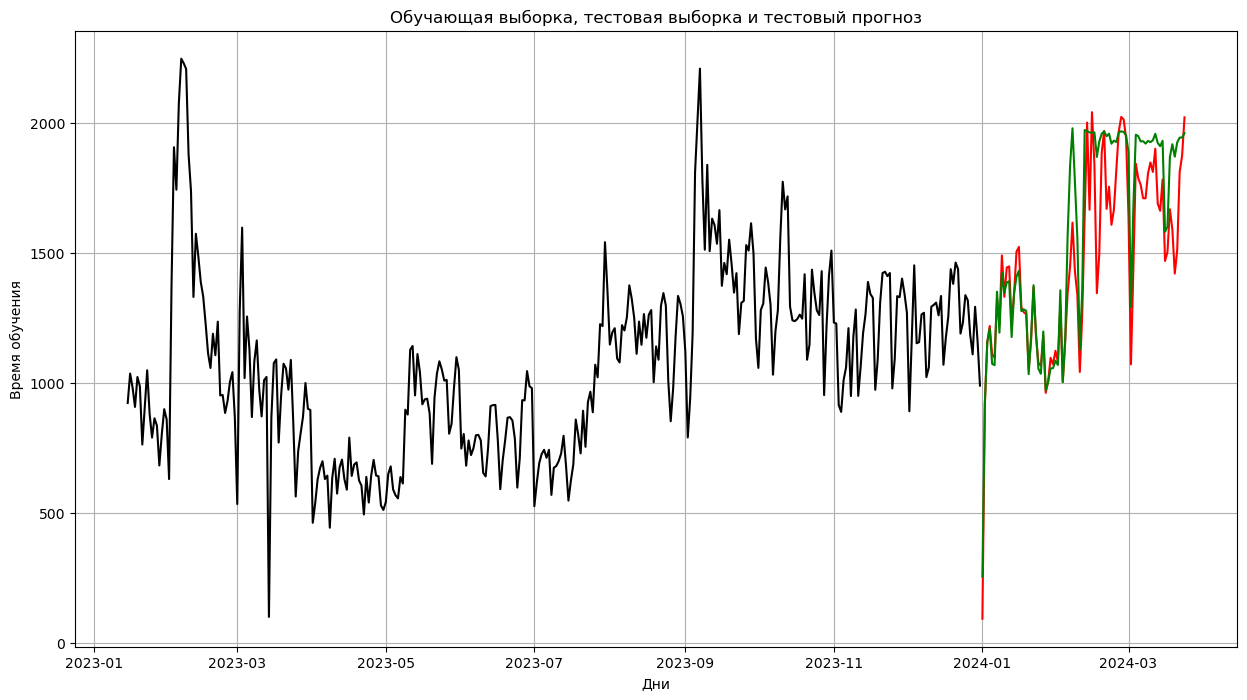

In [90]:
# выведем три кривые (обучающая, тестовая выборка и тестовый прогноз)
plt.figure(figsize=(15,8))
plt.plot(y_train, color = "black")
plt.plot(result_df["test"], color = "red")
plt.plot(result_df["pred"], color = "green")
 
# заголовок и подписи к осям
plt.title("Обучающая выборка, тестовая выборка и тестовый прогноз")
plt.ylabel('Время обучения')
plt.xlabel('Дни')
 
# добавим сетку
plt.grid()
 
plt.show()

Рассчитаем RMSE

In [91]:
mse = mean_squared_error(result_df["test"], result_df["pred"])
print('RMSE:', mse**0.5)

RMSE: 177.4722912151639
